<a href="https://colab.research.google.com/github/Arthur-Barreto/Machine-Vision/blob/main/VisComp_Class_07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Class 7: Dithering and Edge Detection

## Preliminaries

Run the cell below to download the class pack.

In [1]:
import gdown

gdown.download(id='1KaxAQhRDcoOAkYzQBbM65M5lGlkKr87A')

!unzip -o '07.zip'
!rm '07.zip'

Downloading...
From: https://drive.google.com/uc?id=1KaxAQhRDcoOAkYzQBbM65M5lGlkKr87A
To: /content/07.zip
100%|██████████| 1.94M/1.94M [00:00<00:00, 181MB/s]

Archive:  07.zip
  inflating: bay.png                 
  inflating: road-large.png          
  inflating: road-small.png          
  inflating: sdx.py                  


Run the cell below to import the class modules.

If you get import warnings, try using **Ctrl+m .** (notice there is a dot there) to restart the kernel.

In [61]:
import cv2 as cv
import seaborn as sns
import numpy as np

from sdx import *

## Part 1: dithering

### Loading input image

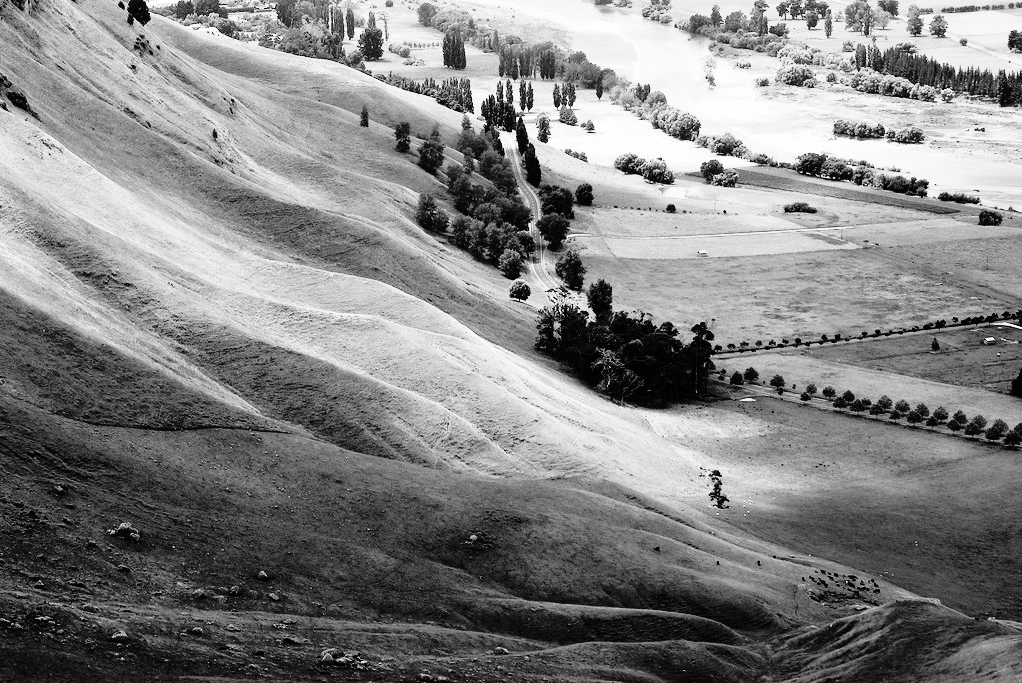

In [62]:
image = cv_grayread('bay.png', asfloat=True)

cv_imshow(image)

### Defining quantization level

In [69]:
NUM_LEVELS = 3

### Activity 1a

Replace the first line with a calculation such that the second line provides a list of **equally-spaced** gray levels.

The first level of this list must be `0` and the last level must be `255`. *(the current code is clearly wrong because the last level is `3`)*

In [70]:
step = 255 / (NUM_LEVELS - 1) # replace this line with your code

levels = [round(index * step) for index in range(NUM_LEVELS)]

levels

[0, 128, 255]

### Activity 2a

Replace the second line such that the third line obtains the closest level to `level` in `levels`.

**Bonus:** do this without loops.

In [71]:
level = 127 # replace this value to test your code

index = round(level/step) # replace this line with your code

closest_level = levels[index]
closest_level

128

### Activity 3a

Using what you learned in the previous two activities, write a function that quantizes a gray level.

**Bonus:** calculate the closest level on-the-fly, without assuming the existence of the `levels` list.

In [73]:
def closest(level):

    if level < 0:
        return 0

    if level > 255:
        return 255

    step = 255 / (NUM_LEVELS - 1)
    index = round(level/step)

    return round(index * step)

### Challenge

Using the `closest` function, implement a dithering function as explained by the teacher.

If you copy code from external sources, it must be fully consistent with how the teacher explained it.

In [105]:
def dithering(image):
    output_image = image.copy()
    height, width = image.shape

    out_of_range = 0

    for y in range(height):
        for x in range(width):
            level = closest(output_image[y,x])
            error = level - output_image[y,x]

            if (x + 1) > width:
                out_of_range = 1
            if (y + 1) > height:
                out_of_range = 1
            if (x - 1) < 0:
                out_of_range = 1
            if (y - 1) < 0:
                out_of_range = 1

            if not out_of_range:
                output_image[y,x+1] += round((-7/16) * error)
                output_image[y+1,x+1] += round((-1/16) * error)
                output_image[y+1,x] += round((-5/16) * error)
                output_image[y-1,x-1] += round((-3/16) * error)

    return output_image

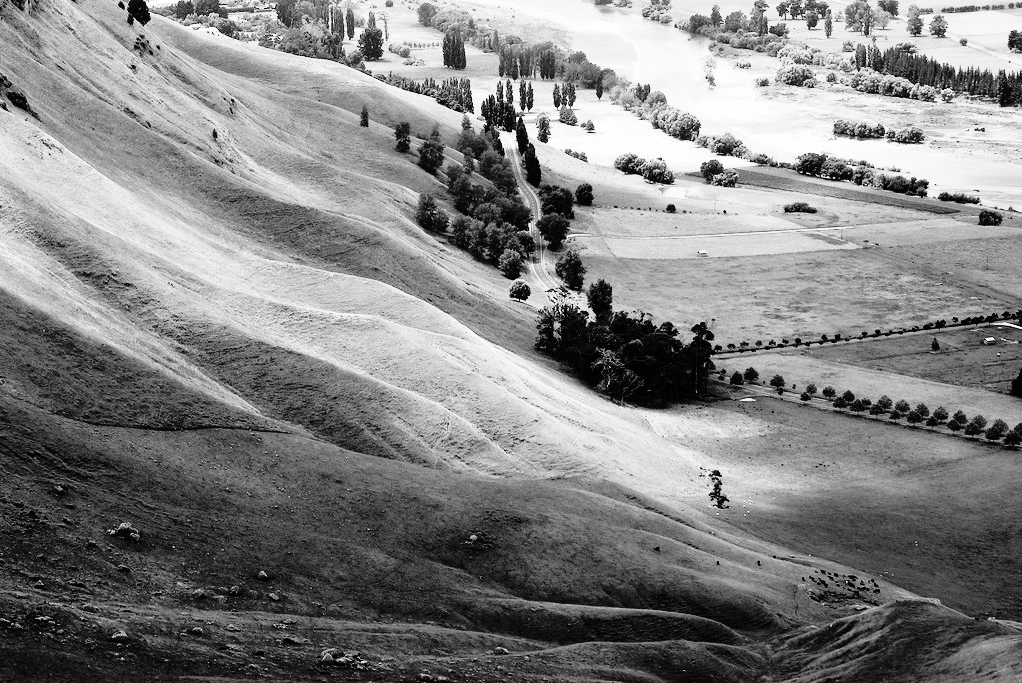

In [106]:
cv_imshow(dithering(image))

## Part 2: line detection

### Defining Hough precisions

In [120]:
ANGLE_PRECISION = 1

DISTANCE_PRECISION = 1

### Loading input image

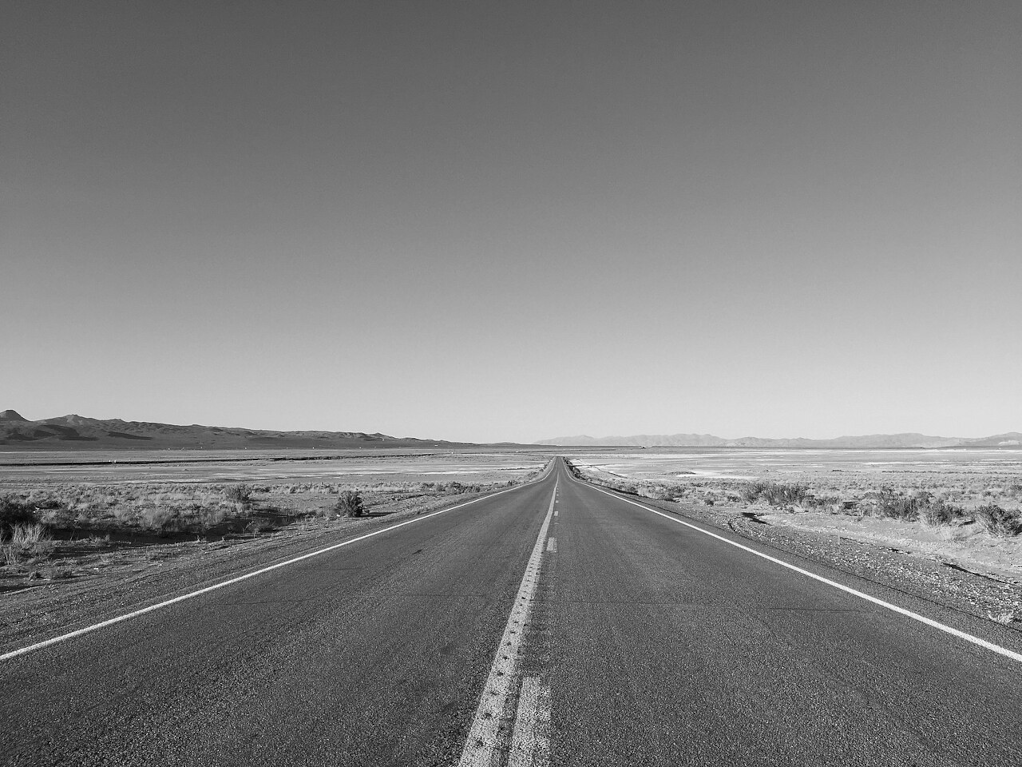

In [134]:
image = cv_grayread('road-large.png')

height, width = image.shape

cv_imshow(image)

### Detecting Canny edges

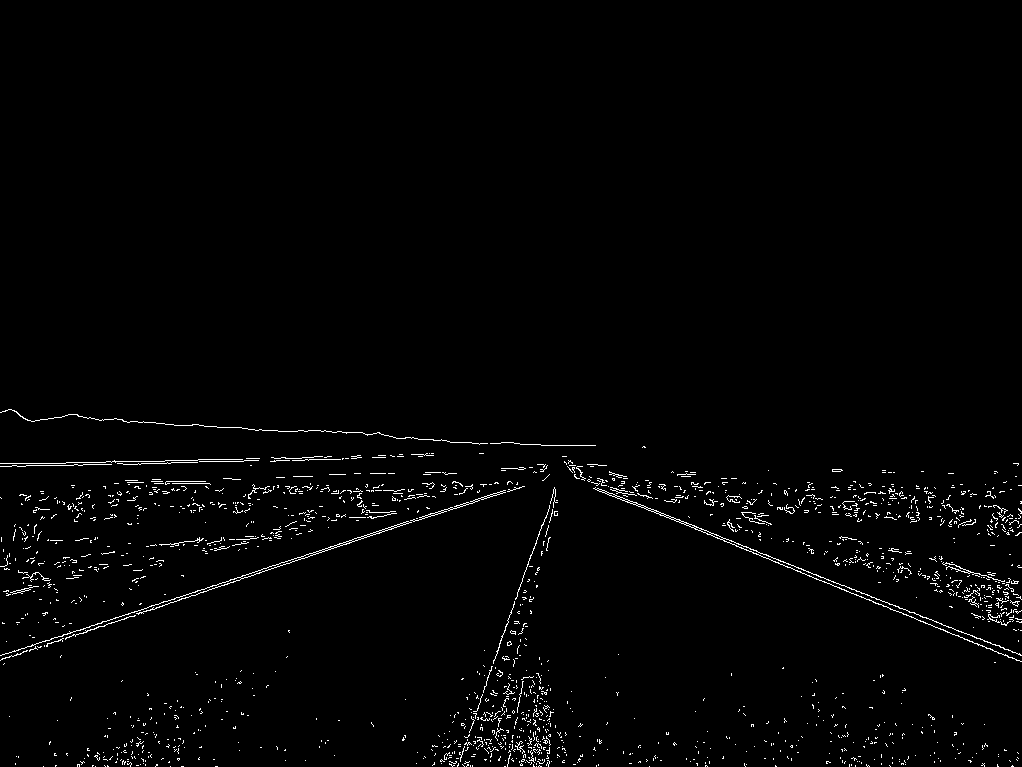

In [135]:
canny = cv.Canny(image, 300, 400)

canny_y, canny_x = (canny == 255).nonzero()

cv_imshow(canny)

### Calculating quantized angles

In [136]:
step_angle = (np.pi / 180) * ANGLE_PRECISION

num_angles = int(np.pi / step_angle)

angles = [index * step_angle for index in range(num_angles)]

First five angles

In [137]:
angles[:5]

[0.0,
 0.017453292519943295,
 0.03490658503988659,
 0.05235987755982989,
 0.06981317007977318]

Last five angles

In [138]:
angles[-5:]

[3.0543261909900767,
 3.07177948351002,
 3.0892327760299634,
 3.1066860685499065,
 3.12413936106985]

### Calculating quantized distances

In [139]:
max_distance = np.sqrt(width**2 + height**2)

num_distances = round(2 * max_distance / DISTANCE_PRECISION)

distances = [index * DISTANCE_PRECISION - max_distance for index in range(num_distances)]

First five distances:

In [140]:
distances[:5]

[-1277.8000626076052,
 -1276.8000626076052,
 -1275.8000626076052,
 -1274.8000626076052,
 -1273.8000626076052]

Last five distances:

In [141]:
distances[-5:]

[1273.1999373923948,
 1274.1999373923948,
 1275.1999373923948,
 1276.1999373923948,
 1277.1999373923948]

### Calculating accumulation matrix

In [142]:
matrix = np.zeros((num_distances, num_angles))

for y, x in zip(canny_y, canny_x):
  for j, t in enumerate(angles):
    r = x * np.cos(t) + y * np.sin(t)
    i = round((r + max_distance) / DISTANCE_PRECISION)
    matrix[i, j] += 1

### Visualizing accumulation matrix

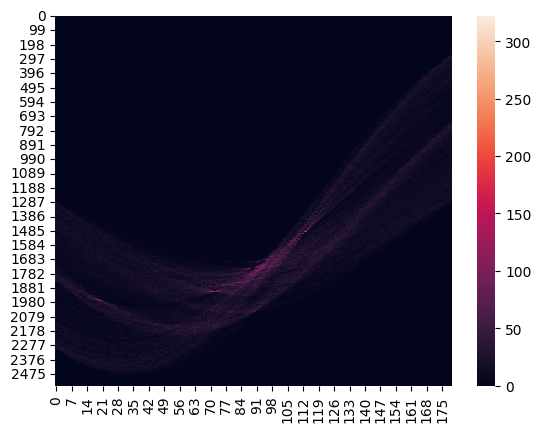

In [143]:
sns.heatmap(matrix);

### Finding best line

In [144]:
max_i, max_j = np.unravel_index(matrix.argmax(), matrix.shape)

t = angles[max_j]

r = distances[max_i]

### Drawing best line

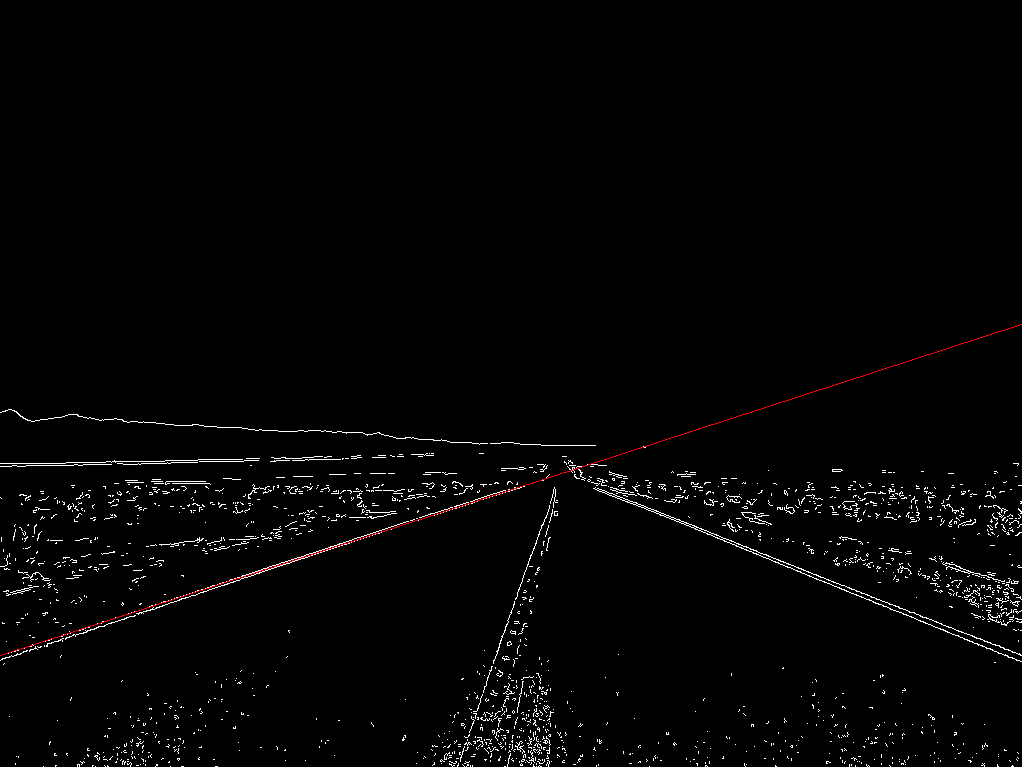

In [145]:
output_image = cv.cvtColor(canny, cv.COLOR_GRAY2BGR)

a_x = 0
a_y = round((r - a_x * np.cos(t)) / np.sin(t))

b_x = width - 1
b_y = round((r - b_x * np.cos(t)) / np.sin(t))

cv.line(output_image, (a_x, a_y), (b_x, b_y), (0, 0, 255))

cv_imshow(output_image)

You can click on the toc.png tab to the left to browse by section.